In [44]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import metrics
import pandas as pd
import time
import scipy

# Data Pre-Processing

In [5]:
#load attributes csv file
attribute = pd.read_csv("celeba.csv")

#"attribute" is a dictionary containing several attributes for each image
#attribute.keys()

In [6]:
#let us list all the files in the image directory
path = "img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant rows in attributes
attribute = attribute[:20000]

Number of images: 20000


## Creating training and validation datasets

In [7]:
# select first 15000 rows for training dataset
train = attribute[:15000]
train = train['Young']

# select last 5000 rows for test dataset
test = attribute[15000:20000]
test = test['Young']

In [10]:
is_Young = train==1
is_Old = train==-1

# subset training set by young/old
train_y = train[is_Young] 
train_o = train[is_Old]

n_old = len(train_o)

Of the 15,000 images in the training data, 3331 are old. We will create a balanced dataset with all the old persons.

In [11]:
# sample 3331 observations from all young data in training set
onp.random.seed(0)
y_pindex = onp.random.choice(len(train_y), n_old, replace=False)
o_pindex = onp.asarray(list(range(n_old)))

In [14]:
train_n = 2665 # 80% of number of old samples
val_n = len(train_o) - train_n # 20% of number of old samples

# select prelim training & validation data
ptrain_y = train_y.iloc[y_pindex[:train_n]]
pval_y = train_y.iloc[y_pindex[train_n:]]

ptrain_o = train_o.iloc[o_pindex[:train_n]]
pval_o = train_o.iloc[o_pindex[train_n:]]

# collate prelim training data (5330 obs, 50% each class)
ptrain = ptrain_y.append(ptrain_o)
ptrain = ptrain.sample(frac=1) # shuffle training set

# collate prelim test data (1332 obs, 50% each class)
pval = pval_y.append(pval_o)
pval = pval.sample(frac=1) # shuffle validation set

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. 

`pval` is a 1 x 1332 array with the indicator values $\{-1, 1\}$ for old and young. 

## Loading images

The images were loaded in grayscale with an initial size of 218 by 178 pixels. The pixel intensity was then rescaled to [0,1]. To remove parts of the image irrelevant to a person's age (outside of the face), the images were cropped to only include the range [50:185, 40:135]. The final images used for analysis are 135 by 95 pixels.

In [17]:
h = 218 # original image height
w = 178 # original image weight
h_n = 185-50 # height after cropping
w_n = 135-40 # width after cropping

In [18]:
# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,h_n,w_n))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptrain_img[k,:,:] = im

In [19]:
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_img = onp.zeros((nval_img,h_n,w_n))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    pval_img[k,:,:] = im

In [20]:
# load the images from the test set
ntest_img = 5000
ptest_img = onp.zeros((ntest_img,h_n,w_n))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    im = im[50:185,40:135] # crop to face
    ptest_img[k,:,:] = im

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptrain_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = ptrain.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = pval_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = pval.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptest_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = test.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. `ptrain_img` is a 5330 x 135 x 95 array that contains the relevant images for the preliminary training data. 

`pval` is a 1 x 1332 array with the indicator values $\{-1, 1\}$ for old and young. `pval_img`is a 1332 x 135 x 95 array that contains the relevant images for the preliminary validation data. 

`test` is a 1 x 5000 array with with the indicator values $\{-1, 1\}$ for old and young. `ptest_img`is a 5000 x 135 x 95 array that contains the relevant images for the test data. 

In [21]:
data_train = ptrain_img.reshape(5330, h_n*w_n)
y_train = ptrain.to_numpy(copy=True)

data_val = pval_img.reshape(1332, h_n*w_n)
y_val = pval.to_numpy(copy=True)

data_test = ptest_img.reshape(5000, h_n*w_n)
y_test = test.to_numpy(copy=True)

# Optimisation

Logistic regression loss function with penalty:
$$ \frac{1}{N} \, \sum_{i=1}^N \log(1 + \exp(-y_i \, \langle \beta, x_i \rangle)) + \frac{\lambda}{N} \| \beta \|^2$$

Logistic probability:
$$P(y=1 | x) = \frac{1}{1 + \exp(- \langle \beta, x \rangle)}$$

We define the loss, prediction, accuracy functions and vectorise them accordingly.

In [22]:
def prediction_single(beta, x):
    """ beta is a vector of dimension 10000, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

#make a prediction on a whole dataset
prediction_data = jax.vmap(prediction_single, in_axes=(None,0))

def loss_single(beta,x,y):
    """
    beta: vector of dimension 100*100
    x: vector of dimension 100*100
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on. whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

def loss(beta, data, y):
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) + np.mean((beta)**2)

grad_loss = jax.jit(jax.grad(loss))

def accuracy(beta, data, y, threshold):
    pred = prediction_data(beta, data)
    prediction_binary = (pred > threshold).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    return np.mean(prediction_sign == y)

## Naive Classifier

Our model should beat a naive classifier that classifies every person as young. Since the dataset is imbalanced, such a classifier is expected to have a test classification accuracy rate of 78.58%.

In [23]:
c = onp.ones(5000)
sum(c==y_test)/5000

0.7858

For each optimisation method, we need to plot the ROC curve and report the AUC.

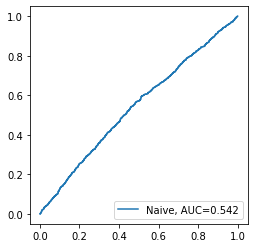

In [99]:
def plot_ROC(model, method):
    y_pred_proba = prediction_data(model,data_test)
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(fpr,tpr,label=method+", AUC="+"{0:.3f}".format(auc))
    plt.legend(loc=4)
    plt.show()
    
plot_ROC(beta_init, "Naive")

Initialise $\beta \sim N(0, \frac{1}{\sqrt{D}})$ where $D=135*95$

In [24]:
D = h_n*w_n
onp.random.seed(0)
beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

## Gradient Descent

In [126]:
n_iter = 500
learning_rate = 0.001
loss_train_hist = []; loss_val_hist = []
acc_train_hist = []; acc_val_hist = []

beta = onp.copy(beta_init)

best_beta_gd = onp.zeros(D)

start = time.time()
for k in range(n_iter):
    gradient = grad_loss(beta, data_train, y_train)
    beta = beta - learning_rate * gradient
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)

    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    if len(loss_val_hist)>0:
        if loss_val <= loss_val_hist[-1]:
            best_beta_gd = beta
        
    #acc_train = accuracy(beta, data_train, y_train)
    #acc_val = accuracy(beta, data_val, y_val) 
    
    #acc_train_hist.append(acc_train)
    #acc_val_hist.append(acc_val)
    
    timing = time.time() - start
    print("Iteration:{0:.0f} \t Time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(k, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

Iteration:0 	 Time:4 	 Loss(train):0.702 	 Loss(val):0.701
Iteration:1 	 Time:8 	 Loss(train):0.693 	 Loss(val):0.690
Iteration:2 	 Time:14 	 Loss(train):0.691 	 Loss(val):0.688
Iteration:3 	 Time:19 	 Loss(train):0.690 	 Loss(val):0.687
Iteration:4 	 Time:23 	 Loss(train):0.690 	 Loss(val):0.687
Iteration:5 	 Time:27 	 Loss(train):0.689 	 Loss(val):0.686
Iteration:6 	 Time:32 	 Loss(train):0.688 	 Loss(val):0.685
Iteration:7 	 Time:37 	 Loss(train):0.687 	 Loss(val):0.685
Iteration:8 	 Time:41 	 Loss(train):0.687 	 Loss(val):0.684
Iteration:9 	 Time:46 	 Loss(train):0.686 	 Loss(val):0.683
Iteration:10 	 Time:50 	 Loss(train):0.685 	 Loss(val):0.683
Iteration:11 	 Time:55 	 Loss(train):0.685 	 Loss(val):0.682
Iteration:12 	 Time:59 	 Loss(train):0.684 	 Loss(val):0.682
Iteration:13 	 Time:63 	 Loss(train):0.683 	 Loss(val):0.681
Iteration:14 	 Time:68 	 Loss(train):0.683 	 Loss(val):0.681
Iteration:15 	 Time:72 	 Loss(train):0.682 	 Loss(val):0.680
Iteration:16 	 Time:77 	 Loss(train)

Iteration:133 	 Time:589 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:134 	 Time:594 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:135 	 Time:598 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:136 	 Time:603 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:137 	 Time:608 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:138 	 Time:612 	 Loss(train):0.649 	 Loss(val):0.653
Iteration:139 	 Time:617 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:140 	 Time:621 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:141 	 Time:626 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:142 	 Time:630 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:143 	 Time:635 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:144 	 Time:638 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:145 	 Time:642 	 Loss(train):0.648 	 Loss(val):0.652
Iteration:146 	 Time:645 	 Loss(train):0.647 	 Loss(val):0.652
Iteration:147 	 Time:649 	 Loss(train):0.647 	 Loss(val):0.652
Iteration:148 	 Time:653 	 Loss(train):0.647 	 Loss(val

Iteration:263 	 Time:1143 	 Loss(train):0.634 	 Loss(val):0.641
Iteration:264 	 Time:1147 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:265 	 Time:1152 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:266 	 Time:1156 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:267 	 Time:1161 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:268 	 Time:1166 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:269 	 Time:1173 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:270 	 Time:1177 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:271 	 Time:1182 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:272 	 Time:1187 	 Loss(train):0.633 	 Loss(val):0.641
Iteration:273 	 Time:1192 	 Loss(train):0.633 	 Loss(val):0.640
Iteration:274 	 Time:1197 	 Loss(train):0.632 	 Loss(val):0.640
Iteration:275 	 Time:1202 	 Loss(train):0.632 	 Loss(val):0.640
Iteration:276 	 Time:1206 	 Loss(train):0.632 	 Loss(val):0.640
Iteration:277 	 Time:1211 	 Loss(train):0.632 	 Loss(val):0.640
Iteration:278 	 Time:1215 	 Loss(train):

Iteration:392 	 Time:1670 	 Loss(train):0.623 	 Loss(val):0.633
Iteration:393 	 Time:1675 	 Loss(train):0.623 	 Loss(val):0.633
Iteration:394 	 Time:1680 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:395 	 Time:1684 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:396 	 Time:1689 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:397 	 Time:1694 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:398 	 Time:1699 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:399 	 Time:1704 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:400 	 Time:1709 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:401 	 Time:1714 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:402 	 Time:1719 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:403 	 Time:1725 	 Loss(train):0.622 	 Loss(val):0.633
Iteration:404 	 Time:1731 	 Loss(train):0.622 	 Loss(val):0.632
Iteration:405 	 Time:1735 	 Loss(train):0.622 	 Loss(val):0.632
Iteration:406 	 Time:1740 	 Loss(train):0.622 	 Loss(val):0.632
Iteration:407 	 Time:1745 	 Loss(train):

Text(0.5, 1.0, 'Naive Gradient Descent')

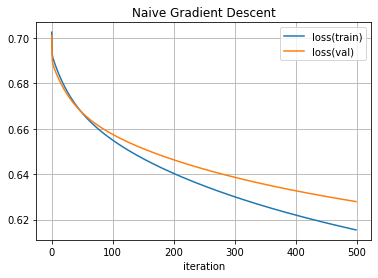

In [129]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("Naive Gradient Descent")

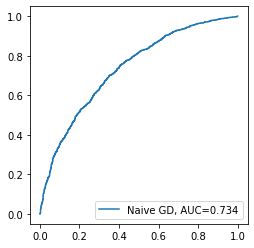

In [130]:
plot_ROC(best_beta_gd, "Naive GD")

## Stochastic Gradient Descent

In [113]:
n_epoch = 100
batch_size=100  #size of the mini-batch
beta = onp.copy(beta_init)
mov_avg_param = 0

learning_rate = 0.001
loss_train_hist = []
loss_val_hist = []

#initialize the gradient
gradient = grad_loss(beta, data_train, y_train)
best_beta_sgd = onp.zeros(D)

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch

        #first option
        #============
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

        #second option
        #============
        #consider the batches sequentially
        #index_ = onp.arange(k*batch_size, (k+1)*batch_size) % ntrain_img
        
        gradient_local = grad_loss(beta, data_train[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    
    if len(loss_val_hist)>0:
        if loss_val <= loss_val_hist[-1]:
            best_beta_sgd = beta
        
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    timing = time.time() - start
    print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

epoch:0 	 time:2 	 Loss(train):0.668 	 Loss(val):0.667
epoch:1 	 time:7 	 Loss(train):0.654 	 Loss(val):0.656
epoch:2 	 time:10 	 Loss(train):0.647 	 Loss(val):0.652
epoch:3 	 time:12 	 Loss(train):0.653 	 Loss(val):0.657
epoch:4 	 time:15 	 Loss(train):0.637 	 Loss(val):0.644
epoch:5 	 time:18 	 Loss(train):0.633 	 Loss(val):0.641
epoch:6 	 time:21 	 Loss(train):0.626 	 Loss(val):0.635
epoch:7 	 time:23 	 Loss(train):0.622 	 Loss(val):0.632
epoch:8 	 time:26 	 Loss(train):0.621 	 Loss(val):0.635
epoch:9 	 time:29 	 Loss(train):0.614 	 Loss(val):0.627
epoch:10 	 time:31 	 Loss(train):0.613 	 Loss(val):0.626
epoch:11 	 time:34 	 Loss(train):0.611 	 Loss(val):0.625
epoch:12 	 time:36 	 Loss(train):0.612 	 Loss(val):0.628
epoch:13 	 time:39 	 Loss(train):0.609 	 Loss(val):0.624
epoch:14 	 time:41 	 Loss(train):0.607 	 Loss(val):0.623
epoch:15 	 time:44 	 Loss(train):0.606 	 Loss(val):0.622
epoch:16 	 time:46 	 Loss(train):0.606 	 Loss(val):0.623
epoch:17 	 time:49 	 Loss(train):0.604 	 Lo

Text(0.5, 1.0, 'Stochastic Gradient Descent')

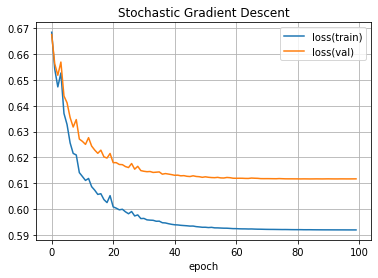

In [115]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")

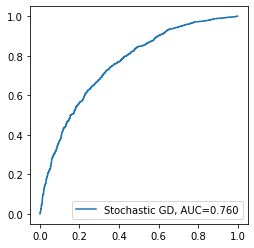

In [117]:
plot_ROC(best_beta_sgd, "Stochastic GD")

In [122]:
acc_thres = []
for i in list(range(1,11)):
    acc_thres.append(accuracy(best_beta_sgd, data_test, y_test, i/10))
acc_thres.index(max(acc_thres))

2

## Stochastic Gradient Descent + Momentum

In [132]:
n_epoch = 100
batch_size=100  #size of the mini-batch
beta = onp.copy(beta_init)
mov_avg_param = 0.8

learning_rate = 0.001
loss_train_hist = []
loss_val_hist = []

#initialize the gradient
gradient = grad_loss(beta, data_train, y_train)
best_beta_sgdm = onp.zeros(D)

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch

        #first option
        #============
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)

        #second option
        #============
        #consider the batches sequentially
        #index_ = onp.arange(k*batch_size, (k+1)*batch_size) % ntrain_img
        
        gradient_local = grad_loss(beta, data_train[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    
    if len(loss_val_hist)>0:
        if loss_val <= loss_val_hist[-1]:
            best_beta_sgdm = beta
        
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    timing = time.time() - start
    print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                 timing, 
                                                                                                loss_train, 
                                                                                                loss_val))

epoch:0 	 time:3 	 Loss(train):0.673 	 Loss(val):0.674
epoch:1 	 time:8 	 Loss(train):0.655 	 Loss(val):0.657
epoch:2 	 time:10 	 Loss(train):0.652 	 Loss(val):0.655
epoch:3 	 time:13 	 Loss(train):0.642 	 Loss(val):0.646
epoch:4 	 time:16 	 Loss(train):0.636 	 Loss(val):0.642
epoch:5 	 time:19 	 Loss(train):0.629 	 Loss(val):0.639
epoch:6 	 time:21 	 Loss(train):0.625 	 Loss(val):0.636
epoch:7 	 time:24 	 Loss(train):0.621 	 Loss(val):0.634
epoch:8 	 time:27 	 Loss(train):0.617 	 Loss(val):0.631
epoch:9 	 time:30 	 Loss(train):0.614 	 Loss(val):0.628
epoch:10 	 time:33 	 Loss(train):0.614 	 Loss(val):0.629
epoch:11 	 time:36 	 Loss(train):0.611 	 Loss(val):0.626
epoch:12 	 time:39 	 Loss(train):0.610 	 Loss(val):0.625
epoch:13 	 time:42 	 Loss(train):0.608 	 Loss(val):0.623
epoch:14 	 time:45 	 Loss(train):0.607 	 Loss(val):0.623
epoch:15 	 time:48 	 Loss(train):0.606 	 Loss(val):0.622
epoch:16 	 time:51 	 Loss(train):0.605 	 Loss(val):0.621
epoch:17 	 time:54 	 Loss(train):0.605 	 Lo

Text(0.5, 1.0, 'Stochastic Gradient Descent')

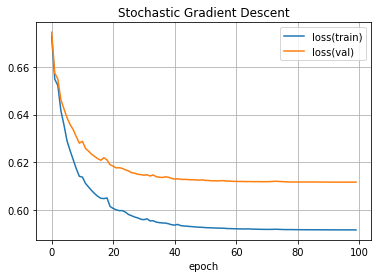

In [136]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")

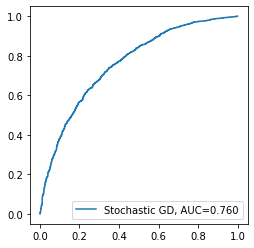

In [137]:
plot_ROC(best_beta_sgdm, "Stochastic GD")

In [138]:
acc_thres = []
for i in list(range(1,11)):
    acc_thres.append(accuracy(best_beta_sgdm, data_test, y_test, i/10))
acc_thres

[DeviceArray(0.7856, dtype=float64),
 DeviceArray(0.7928, dtype=float64),
 DeviceArray(0.8092, dtype=float64),
 DeviceArray(0.7904, dtype=float64),
 DeviceArray(0.7176, dtype=float64),
 DeviceArray(0.5584, dtype=float64),
 DeviceArray(0.3714, dtype=float64),
 DeviceArray(0.2486, dtype=float64),
 DeviceArray(0.2166, dtype=float64),
 DeviceArray(0.2142, dtype=float64)]

Stochastic Gradient Descent has an accuracy of 71.58%.

## L-BFGS

In [25]:
def loss_wrapper(beta):
    """ only one argument """
    return loss(beta, data_train, y_train)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta))

In [40]:
loss_train_hist = []; loss_val_hist = []
acc_val_hist = []
time_hist = []  # to save the compute time

best_beta_bfgs = onp.zeros(D) # to save best model
beta = onp.copy(beta_init)

def save_traj(beta):
    global best_beta_bfgs
    """ a function that saves a few statistics for later analysis"""
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    timing = time.time() - start
    
    print("Time:{0:3f} \t Loss(train):{1:.3f} \t Loss(val):{2:.3f}".format(timing, loss_train, loss_val))
    
    time_hist.append(timing)
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)

    #acc_val = accuracy(beta, data_val, y_val)
    #acc_val_list.append(accuracy_val)
    
    if loss_val <= loss_val_hist[-1]:
        best_beta_bfgs = beta
        
#run LBFGS
start = time.time()
onp.random.seed(0)
traj = scipy.optimize.minimize(fun = loss_wrapper, # function to minimize
                                x0 = onp.array(beta_init), # initial guess
                                method='L-BFGS-B',  # we want to use L-BFGS
                                jac=gradient_wrapper, # function that computes the gradient
                                callback=save_traj, # a function used to save some results for later plotting
                                options={"maxiter":100})  # maximum number of iterations

Time:12.112750 	 Loss(train):0.693 	 Loss(val):0.691
Time:18.162471 	 Loss(train):0.691 	 Loss(val):0.688
Time:23.656901 	 Loss(train):0.689 	 Loss(val):0.686
Time:29.021730 	 Loss(train):0.680 	 Loss(val):0.677
Time:34.451313 	 Loss(train):0.669 	 Loss(val):0.668
Time:40.407051 	 Loss(train):0.655 	 Loss(val):0.658
Time:46.304225 	 Loss(train):0.648 	 Loss(val):0.654
Time:53.124964 	 Loss(train):0.645 	 Loss(val):0.653
Time:59.879292 	 Loss(train):0.641 	 Loss(val):0.651
Time:65.122577 	 Loss(train):0.634 	 Loss(val):0.648
Time:70.901713 	 Loss(train):0.624 	 Loss(val):0.642
Time:78.513247 	 Loss(train):0.605 	 Loss(val):0.628
Time:85.101411 	 Loss(train):0.595 	 Loss(val):0.621
Time:95.735050 	 Loss(train):0.593 	 Loss(val):0.619
Time:106.602400 	 Loss(train):0.592 	 Loss(val):0.617
Time:113.987103 	 Loss(train):0.590 	 Loss(val):0.615
Time:123.339943 	 Loss(train):0.585 	 Loss(val):0.612
Time:129.240770 	 Loss(train):0.578 	 Loss(val):0.608
Time:138.988889 	 Loss(train):0.574 	 Loss

Text(0.5, 1.0, 'L-BFGS')

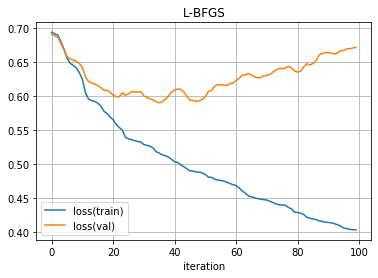

In [41]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

In [58]:
# Plot ROC curve
def plot_ROC(model):
    y_pred_proba = prediction_data(model,data_test)
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(fpr,tpr,label="L-BFGS, AUC="+"{0:.3f}".format(auc))
    plt.legend(loc=4)
    plt.show()

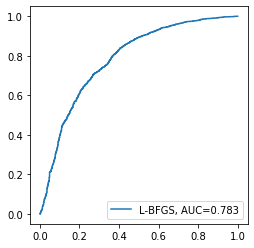

In [59]:
plot_ROC(best_beta_bfgs, "L-BFGS")

In [125]:
acc_thres = []
for i in list(range(1,11)):
    acc_thres.append(accuracy(best_beta_bfgs, data_test, y_test, i/10))
acc_thres

[DeviceArray(0.82, dtype=float64),
 DeviceArray(0.8122, dtype=float64),
 DeviceArray(0.7938, dtype=float64),
 DeviceArray(0.7582, dtype=float64),
 DeviceArray(0.721, dtype=float64),
 DeviceArray(0.6736, dtype=float64),
 DeviceArray(0.6168, dtype=float64),
 DeviceArray(0.5406, dtype=float64),
 DeviceArray(0.4158, dtype=float64),
 DeviceArray(0.2142, dtype=float64)]